In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import defaultdict
import heapq

all_transformed_data = pd.read_csv("./transformed_samples_by_features.csv").drop(columns=["Unnamed: 0"]).values
all_transformed_data

all_feature_names = pd.read_csv("./transformed_samples_by_features.csv").drop(columns=["Unnamed: 0"]).columns
all_feature_names

Index(['AtomicNumber', 'AtomicPeriod', 'AtomicGroup', 'AtomicWeight',
       'EmpiricalRadius', 'CalculaterRadius', 'MolarVolume',
       'Electronegativity', 'AbsoluteMeltingPoint', 'Oxidation_States',
       ...
       'AtomicGroup Inverse Logarithmic', 'AtomicWeight Inverse Logarithmic',
       'EmpiricalRadius Inverse Logarithmic',
       'CalculaterRadius Inverse Logarithmic',
       'MolarVolume Inverse Logarithmic',
       'Electronegativity Inverse Logarithmic',
       'AbsoluteMeltingPoint Inverse Logarithmic',
       'Oxidation_States Inverse Logarithmic',
       'Bond dissociation energy Inverse Logarithmic',
       'Assumed CN Inverse Logarithmic'],
      dtype='object', length=132)

In [7]:
youngs_data = pd.read_csv("./Oxide_glass_1_5_02142020.csv")["Young's modulus E (GPa)"].values
shear_data = pd.read_csv("./Oxide_glass_1_5_02142020.csv")["Shear modulus G (GPa)"].values
poisson_data = pd.read_csv("./Oxide_glass_1_5_02142020.csv")["Poisson's ratio v"].values

In [8]:
#https://analyticsindiamag.com/lasso-regression-in-python-with-machinehack-data-science-hackathon/
from sklearn.linear_model import Lasso
from sklearn import metrics
import math

alpha_powers = [0, 1, 1.5, 2, 2.5]
alpha_vals = []
for i in range(len(alpha_powers)):
    alpha_vals.append(10**(-alpha_powers[i]))
states = [1, 6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71]


def calculate_alpha_rmse(y_data):
    alpha_state_to_rmse_test = {}
    alpha_state_to_rmse_train = {}

    for alpha_val in alpha_vals:
        for state in states:
            X_train, X_test, y_train, y_test = train_test_split(all_transformed_data, y_data, test_size=0.2, random_state=state)
            lasso = Lasso(alpha = alpha_val, max_iter = 150000)
            lasso.fit(X_train, y_train)

            y_pred_test = lasso.predict(X_test)
            y_pred_train = lasso.predict(X_train)
            alpha_state_to_rmse_test[(alpha_val, state)] = math.sqrt(metrics.mean_squared_error(y_test, y_pred_test))
            alpha_state_to_rmse_train[(alpha_val, state)] = math.sqrt(metrics.mean_squared_error(y_train, y_pred_train))
    return alpha_state_to_rmse_train, alpha_state_to_rmse_test

youngs_train, youngs_test = calculate_alpha_rmse(youngs_data)
shear_train, shear_test = calculate_alpha_rmse(shear_data)
poisson_train, poisson_test = calculate_alpha_rmse(poisson_data)

In [9]:
#1. Calculate average RMSE
def average_rmse(train, test):
    train_rmse = defaultdict(float) #alpha, sum RMSE
    for key in train.keys():
        train_rmse[key[0]] += train[key]

    test_rmse = defaultdict(float)
    for key in test.keys():
        test_rmse[key[0]] += test[key]

    train_rmse_averaged = []
    for key in train_rmse:
        train_rmse_averaged.append(train_rmse[key]/len(states))

    test_rmse_averaged = []
    for key in test_rmse:
        test_rmse_averaged.append(test_rmse[key]/len(states))
    return train_rmse_averaged, test_rmse_averaged

youngs_average_rmse_train, youngs_average_rmse_test = average_rmse(youngs_train, youngs_test)
shear_average_rmse_train, shear_average_rmse_test = average_rmse(shear_train, shear_test)
poisson_average_rmse_train, poisson_average_rmse_test = average_rmse(poisson_train, poisson_test)

youngs_average_rmse_train


[18.04472135678352,
 13.975835019943315,
 12.177495475890373,
 11.53471643695426,
 11.204389882865138]

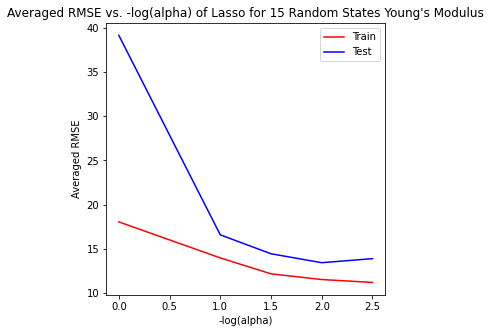

In [10]:
def plot_rmse_alpha(train, test, name):
    plt.rcParams["figure.figsize"] = (5, 5)
    plt.plot(alpha_powers, train, 'r', label = "Train")
    plt.plot(alpha_powers, test, 'b', label = "Test")
    plt.title("Averaged RMSE vs. -log(alpha) of Lasso for 15 Random States " + name)
    plt.ylabel("Averaged RMSE")
    plt.xlabel("-log(alpha)")
    plt.legend()

plot_rmse_alpha(youngs_average_rmse_train, youngs_average_rmse_test, "Young's Modulus")
#From here we know that the most optimal -log(alpha value would be 10^(-2))
#Finer search around "optimal -log(alpha value)"

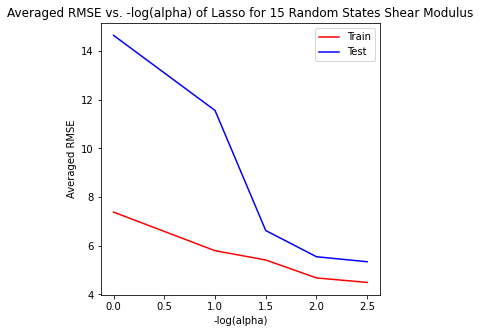

In [11]:
plot_rmse_alpha(shear_average_rmse_train, shear_average_rmse_test, "Shear Modulus") #Try to go further with -3.0, etc since it continues to descend

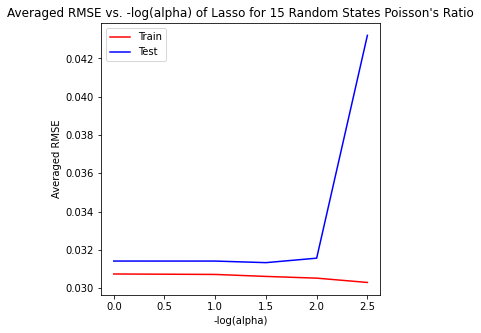

In [12]:
plot_rmse_alpha(poisson_average_rmse_train, poisson_average_rmse_test, "Poisson's Ratio")

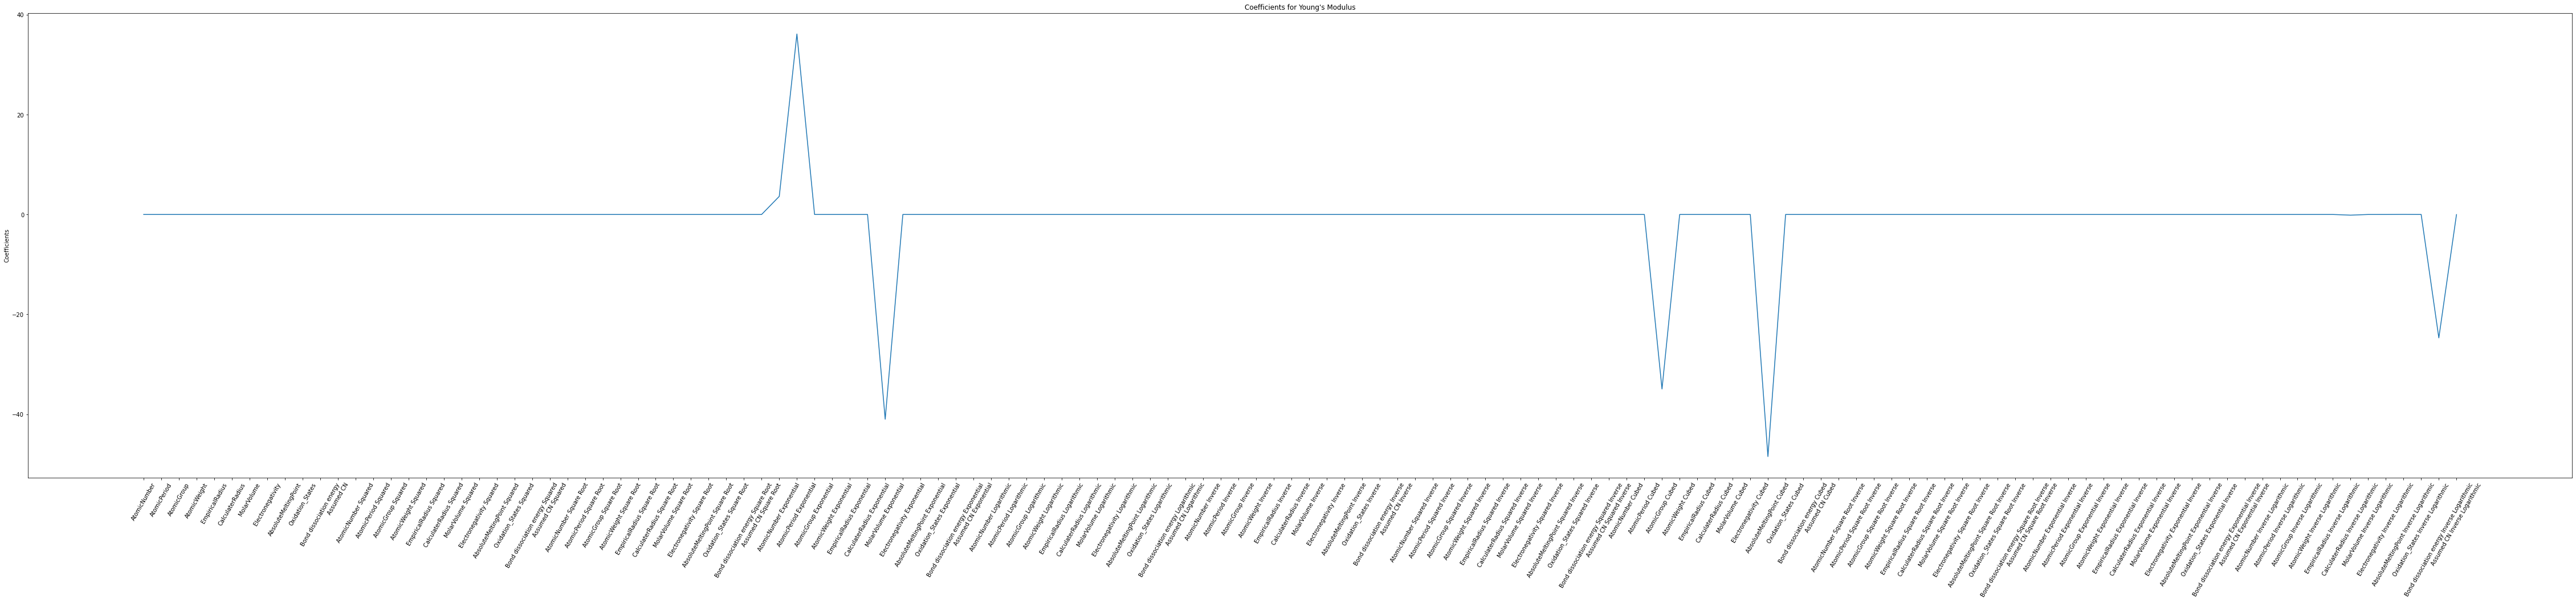

In [13]:
#Using optimal alpha value = 0.1 (young's)
# alpha value = 10^-1.5 (shear)
# alpha value = 10^-2 (poisson)
def lasso_coeffs(alpha_val, column, name):
    lasso = Lasso(alpha = alpha_val)

    X = all_transformed_data
    Y = pd.read_csv("./Oxide_glass_1_5_02142020.csv")[column].values
    plt.rcParams["figure.figsize"] = (80,15)
    lasso_coeff = lasso.fit(X, Y).coef_
    plotting = plt.plot(range(len(all_feature_names)), lasso_coeff)
    plotting = plt.xticks(range(len(all_feature_names)), all_feature_names, rotation=60)
    plotting = plt.ylabel("Coefficients")
    plotting = plt.title("Coefficients for " + name)
    plt.show() #Do cross-validation
    
    return lasso_coeff
youngs_coeffs = lasso_coeffs(10**(-1), "Young's modulus E (GPa)", "Young's Modulus")


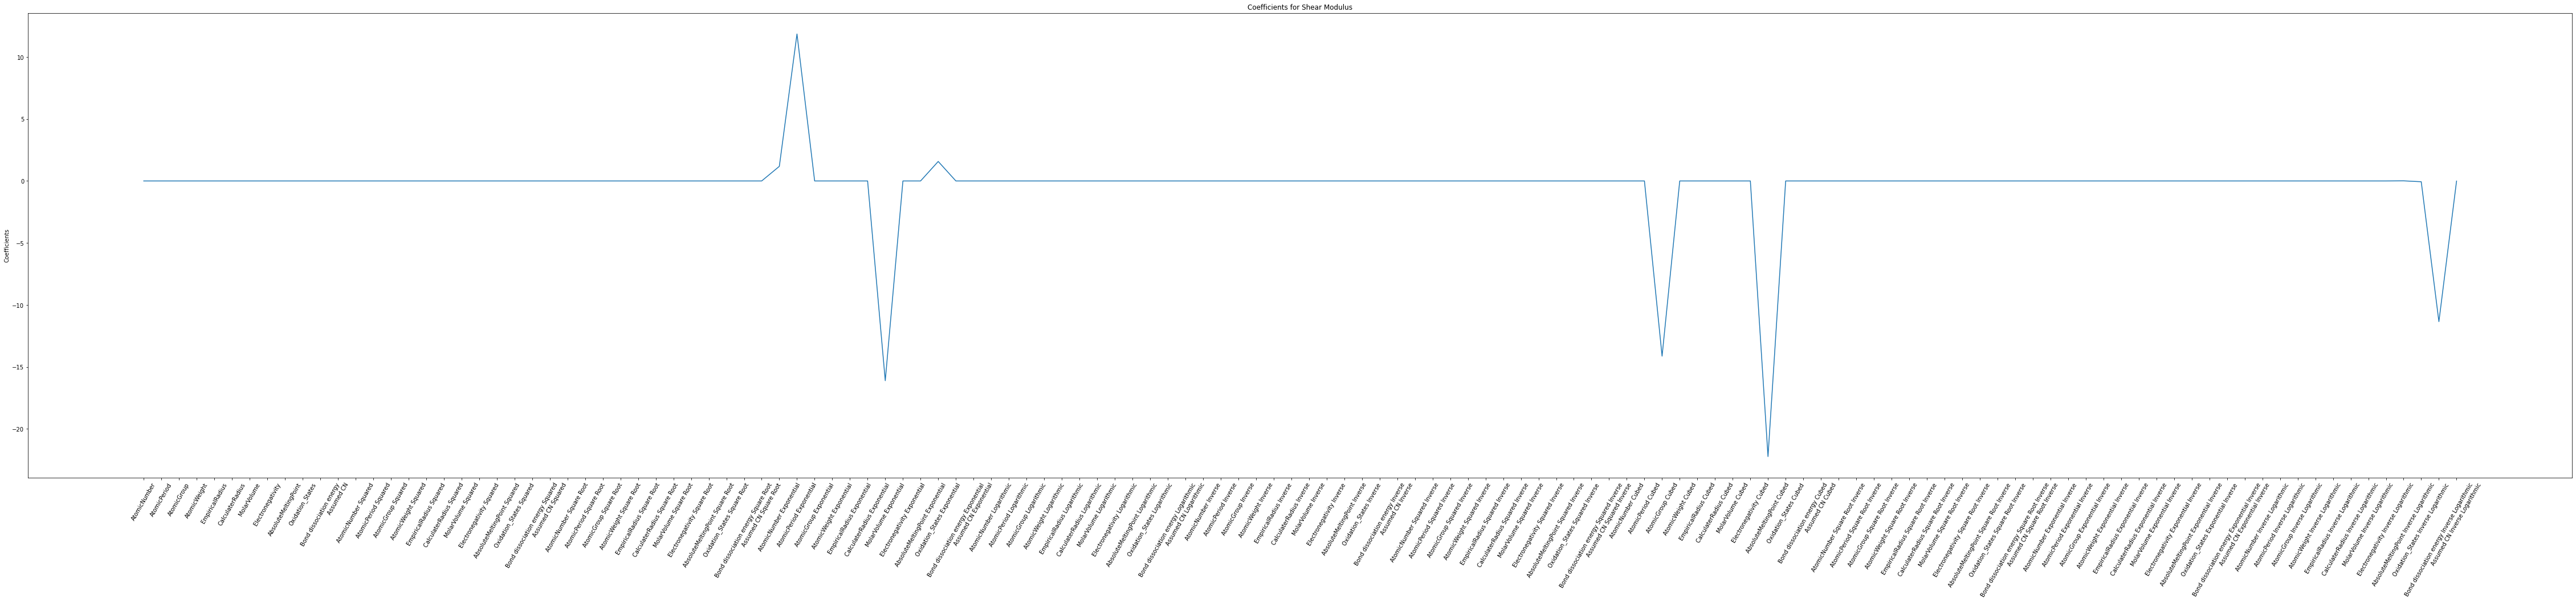

In [14]:
shear_coeffs = lasso_coeffs(10**(-1.5), "Shear modulus G (GPa)", "Shear Modulus")

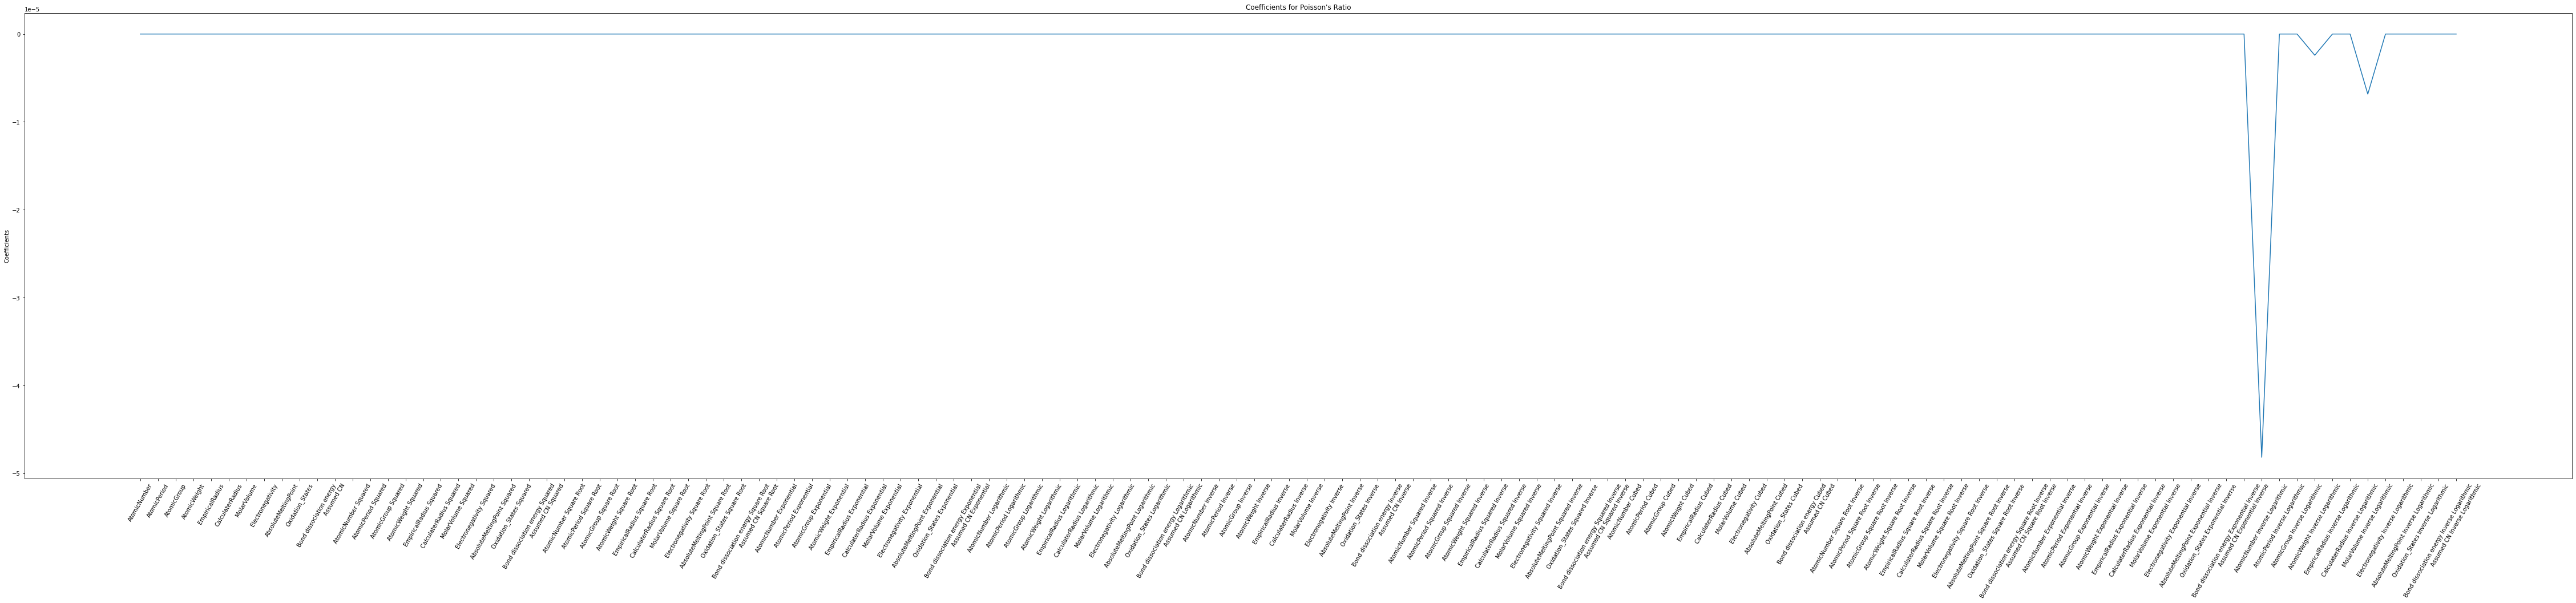

In [15]:
poisson_coeffs = lasso_coeffs(10**(-1.5), "Poisson's ratio v", "Poisson's Ratio") ###########

In [16]:
def coeffs_to_dict(coeffs):
    feature_names_to_coeff = {}
    for i in range(len(all_feature_names)):
        feature_names_to_coeff[all_feature_names[i]] = coeffs[i]
    return feature_names_to_coeff

youngs_coeffs_dict = coeffs_to_dict(youngs_coeffs)
shear_coeffs_dict = coeffs_to_dict(shear_coeffs)
poisson_coeffs_dict = coeffs_to_dict(poisson_coeffs)




In [17]:
def filter_coeff_dicts(d):
    filtered_names_to_coeff = {}
    for feature in d:
        if d[feature] != 0.0 and d[feature] != -0.0:
            filtered_names_to_coeff[feature] = abs(d[feature])
    return filtered_names_to_coeff
youngs_coeffs_dict = filter_coeff_dicts(youngs_coeffs_dict)
shear_coeffs_dict = filter_coeff_dicts(shear_coeffs_dict)
poisson_coeffs_dict = filter_coeff_dicts(poisson_coeffs_dict)

youngs_coeffs_dict

{'AtomicNumber Exponential': 3.6230646345551296,
 'AtomicPeriod Exponential': 36.14284938663423,
 'MolarVolume Exponential': 40.998166203622006,
 'AtomicGroup Cubed': 34.94635985132649,
 'AbsoluteMeltingPoint Cubed': 48.47482385817644,
 'AtomicNumber Inverse Logarithmic': 0.007977857562690554,
 'AtomicWeight Inverse Logarithmic': 0.000824572867140196,
 'CalculaterRadius Inverse Logarithmic': 0.1367575594506194,
 'MolarVolume Inverse Logarithmic': 0.0014983167699157644,
 'AbsoluteMeltingPoint Inverse Logarithmic': 0.016622018590912294,
 'Bond dissociation energy Inverse Logarithmic': 24.70980782275442,
 'Assumed CN Inverse Logarithmic': 0.024963636541216045}

In [18]:
def rank_coeffs(filtered):
    ranked_names = []
    for name in filtered:
        ranked_names.append((name, filtered[name]))
    ranked_names.sort(key = lambda x: x[1], reverse = True)
    return ranked_names

youngs_ranked = rank_coeffs(youngs_coeffs_dict)
shear_ranked = rank_coeffs(shear_coeffs_dict)
poisson_ranked = rank_coeffs(poisson_coeffs_dict)

In [19]:
def select_features(names):
    selected_features = [name for name, val in names]
    #selected_features = selected_features[:10] #alter the number of features are used
    return selected_features

youngs_selected = select_features(youngs_ranked)
shear_selected = select_features(shear_ranked)
poisson_selected = select_features(poisson_ranked)

In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score

def rmse(score):
    rmse = np.sqrt(-score)
    print(f'rmse= {"{:.2f}".format(rmse)}')

estimators = [num for num in range(1, 50)]
def random_forest(selected, drop1, drop2, current):
    selected_data = pd.read_csv("./transformed_samples_by_features.csv").drop(columns=["Unnamed: 0"])
    selected_features_df = pd.DataFrame()
    for feature in selected:
        selected_features_df[feature] = selected_data[feature]
    selected_features_df

    pred = pd.read_csv("./Oxide_glass_1_5_02142020.csv").drop(["Index", "Code", "Glass #", "Author", "Year", "Trademark", "Glass_composition", drop1, drop2], axis = 1)
    X = selected_features_df.iloc[:, 0:len(selected)]
    Y = pred[current]#"Young's modulus E (GPa)"]

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=30)
    
    rmse_test = []
    rmse_train = []
    for i in estimators:
        regressor = RandomForestRegressor(n_estimators=i, random_state=0)
        regressor.fit(X_train, y_train)
        y_pred = regressor.predict(X_test)
        rmse_test.append(math.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    for i in estimators:
        regressor = RandomForestRegressor(n_estimators=i, random_state=0)
        regressor.fit(X_train, y_train)
        y_pred = regressor.predict(X_train)
        rmse_train.append(math.sqrt(metrics.mean_squared_error(y_train, y_pred)))
    return rmse_train, rmse_test
youngs_rmse_train, youngs_rmse_test = random_forest(youngs_selected, "Shear modulus G (GPa)", "Poisson's ratio v", "Young's modulus E (GPa)")
shear_rmse_train, shear_rmse_test = random_forest(shear_selected, "Young's modulus E (GPa)", "Poisson's ratio v", "Shear modulus G (GPa)")
poisson_rmse_train, poisson_rmse_test = random_forest(poisson_selected, "Young's modulus E (GPa)", "Shear modulus G (GPa)", "Poisson's ratio v")

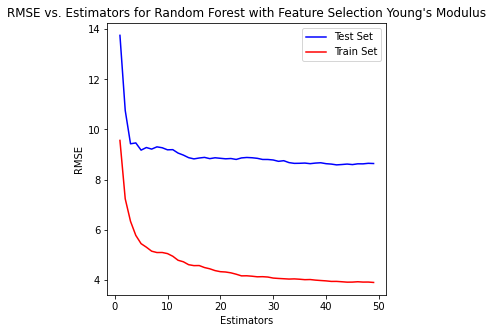

In [21]:
def plot_rmse_estimators(rmse_train, rmse_test, name):
    plt.rcParams["figure.figsize"] = (5, 5)
    plt.plot(estimators, rmse_test, "b", label = "Test Set")
    plt.plot(estimators, rmse_train, "r", label = "Train Set")
    plt.title("RMSE vs. Estimators for Random Forest with Feature Selection " + name)
    plt.xlabel("Estimators")
    plt.ylabel("RMSE")
    plt.legend()
plot_rmse_estimators(youngs_rmse_train, youngs_rmse_test, "Young's Modulus")


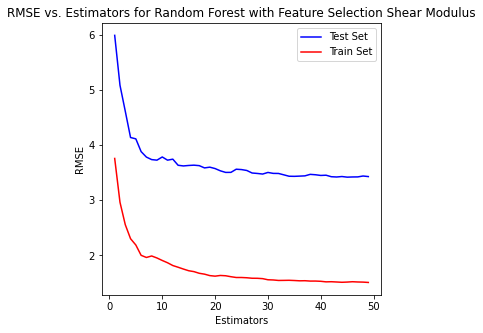

In [22]:
plot_rmse_estimators(shear_rmse_train, shear_rmse_test, "Shear Modulus")


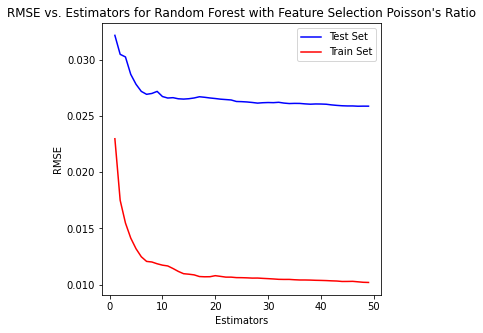

In [23]:
plot_rmse_estimators(poisson_rmse_train, poisson_rmse_test, "Poisson's Ratio")